In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

collectives = ["broadcast", "all_reduce", "all_gather", "reduce_scatter", "all_to_all", "reduce"]
coalesce_collectives = ["all_reduce", "all_gather", "reduce_scatter"]

In [3]:
bench_files = {}
for collective in collectives:
    bench_files[collective] = list(filter(lambda x: "async" not in x and "profiler" not in x, os.listdir(path=f"benchmark_results/{collective}")))
    bench_files[collective] = list(map(lambda x: f"benchmark_results/{collective}/" + x, bench_files[collective]))
    bench_files[collective].sort()

bench_async_files = {}
for collective in collectives:
    bench_async_files[collective] = list(filter(lambda x: "async" in x and "profiler" not in x, os.listdir(path=f"benchmark_results/{collective}")))
    bench_async_files[collective] = list(map(lambda x: f"benchmark_results/{collective}/" + x, bench_async_files[collective]))
    bench_async_files[collective].sort()

coal_files = {}
for collective in coalesce_collectives:
    coal_files[collective] = os.listdir(path=f"coalescing_benchmark_results/{collective}/coalesce")
    coal_files[collective] = list(map(lambda x: f"coalescing_benchmark_results/{collective}/coalesce/" + x, coal_files[collective]))
    coal_files[collective].sort()

coal_default_files = {}
for collective in coalesce_collectives:
    coal_default_files[collective] = os.listdir(path=f"coalescing_benchmark_results/{collective}/default")
    coal_default_files[collective] = list(map(lambda x: f"coalescing_benchmark_results/{collective}/default/" + x, coal_default_files[collective]))
    coal_default_files[collective].sort()

# Min Latency

In [4]:
def get_bench_df(collective: str, async_op: Optional[bool]):
    if not async_op:
        files = bench_files[collective]
    else:
        files = bench_async_files[collective]
    df = pd.read_csv(files[0], header=None).rename(columns={0:"data_size", 1:"time"})
    num_exp = df.shape[0]

    bench_df = df
    bench_df = bench_df.assign(rank=0)
    bench_df = bench_df.assign(experiment=range(num_exp))

    for idx, file in enumerate(files[1:]):
        rank_df = pd.read_csv(file, header=None).rename(columns={0:"data_size", 1:"time"})
        rank_df = rank_df.assign(rank=idx+1)
        rank_df = rank_df.assign(experiment=range(num_exp))
        bench_df = pd.concat([bench_df, rank_df])
        bench_df = bench_df.sort_values(by=["experiment", "rank"])

    return bench_df

def get_coal_df(collective: str, default: Optional[bool]):
    if not default:
        files = coal_files[collective]
    else:
        files = coal_default_files[collective]
    df = pd.read_csv(files[0], header=None).rename(columns={0:"data_size", 1:"time"})
    num_exp = df.shape[0]

    bench_df = df
    bench_df = bench_df.assign(rank=0)
    bench_df = bench_df.assign(experiment=range(num_exp))

    for idx, file in enumerate(files[1:]):
        rank_df = pd.read_csv(file, header=None).rename(columns={0:"data_size", 1:"time"})
        rank_df = rank_df.assign(rank=idx+1)
        rank_df = rank_df.assign(experiment=range(num_exp))
        bench_df = pd.concat([bench_df, rank_df])
        bench_df = bench_df.sort_values(by=["experiment", "rank"])

    return bench_df

In [5]:
def plot_min_latency(collective: str):
    bench_df = get_bench_df(collective, async_op=False)
    min_times_df = bench_df.groupby(["experiment"]).min().loc[:, ["data_size", "time"]]
    bench_async_df = get_bench_df(collective, async_op=True)
    min_times_async_df = bench_async_df.groupby(["experiment"]).min().loc[:, ["data_size", "time"]]

    fig, axs = plt.subplots(2, figsize=[4,5], gridspec_kw={'hspace':0.5, 'wspace':0.3})

    axs[0].scatter(min_times_df["data_size"], min_times_df["time"], s=8, label="Synchronous")
    axs[0].scatter(min_times_async_df["data_size"], min_times_async_df["time"], s=8, alpha=0.3, c="purple", label="Asynchronous")
    axs[0].set_title(f"{collective} Min Latency (ms)")
    axs[0].set_xlabel("Data Size (MB)")
    axs[0].set_ylabel("Latency (ms)")
    axs[0].legend()
    axs[0].grid(True)

    time_variance = min_times_df.groupby(["data_size"]).var()
    sizes = min_times_df.groupby(["data_size"]).groups.keys()
    time_async_variance = min_times_async_df.groupby(["data_size"]).var()
    axs[1].scatter(sizes, time_variance, s=8, c="darkorange", label="Synchronous")
    axs[1].scatter(sizes, time_async_variance, s=8, c="green", alpha=0.3, label="Asynchronous")
    axs[1].set_title(f"{collective} Min Latency Variance")
    axs[1].set_xlabel("Data Size (MB)")
    axs[1].set_ylabel("Latency Variance")
    axs[1].legend()
    axs[1].grid(True)

    plt.savefig(f"figs/{collective}_min_latency.png", bbox_inches="tight")

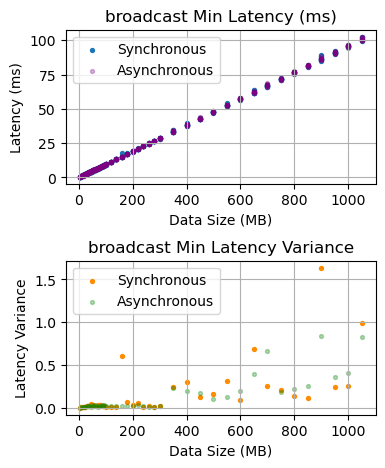

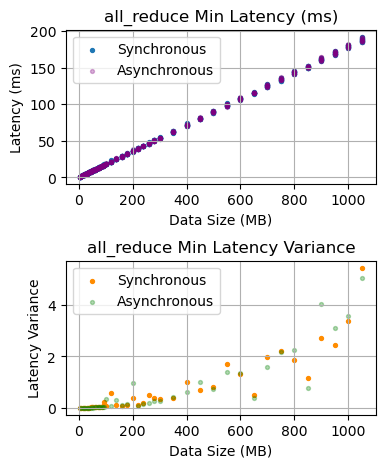

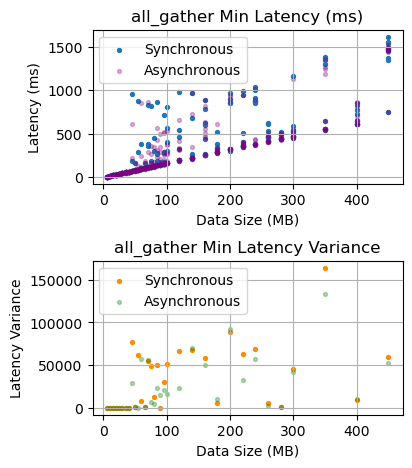

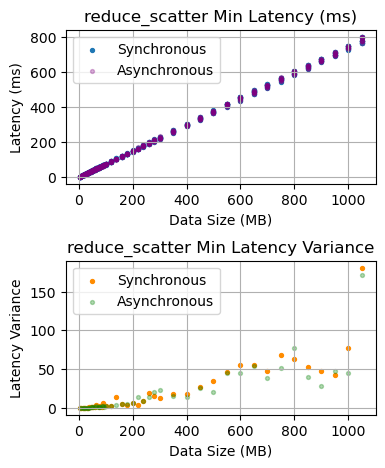

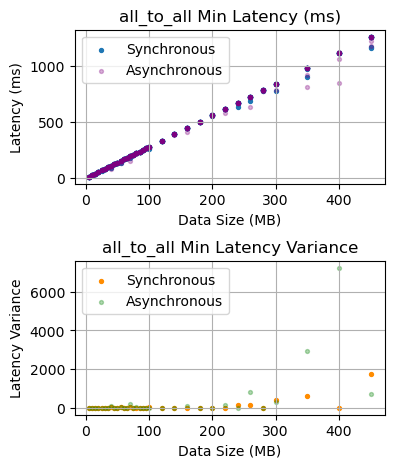

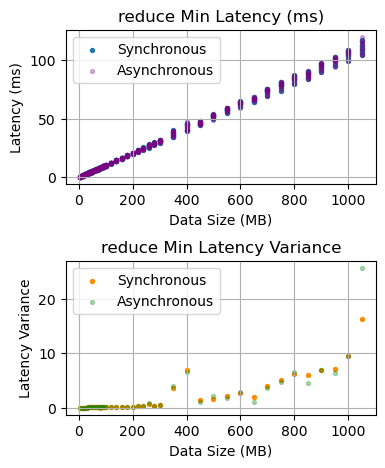

In [6]:
for collective in collectives:
    plot_min_latency(collective)

In [31]:
def plot_mean_median_latency(collective: str):
    bench_df = get_bench_df(collective, async_op=False)
    mean_times_df = bench_df.groupby(["experiment"]).mean().loc[:, ["data_size", "time"]]
    med_times_df = bench_df.groupby(["experiment"]).median().loc[:, ["data_size", "time"]]

    fig, axs = plt.subplots(1, figsize=[5,3])

    axs.scatter(mean_times_df["data_size"], mean_times_df["time"], s=13, c="darkorange", label="Mean")
    axs.scatter(med_times_df["data_size"], med_times_df["time"], s=13, alpha=0.5, c="purple", label="Median")
    axs.set_title(f"{collective} Mean & Median Latency (ms)")
    axs.set_xlabel("Data Size (MB)")
    axs.set_ylabel("Latency (ms)")
    axs.legend()
    axs.grid(True)

    plt.savefig(f"figs/{collective}_mean_med_latency.png", bbox_inches="tight")

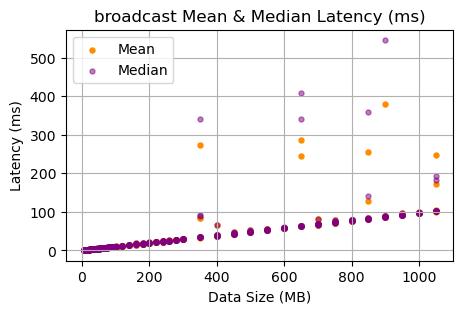

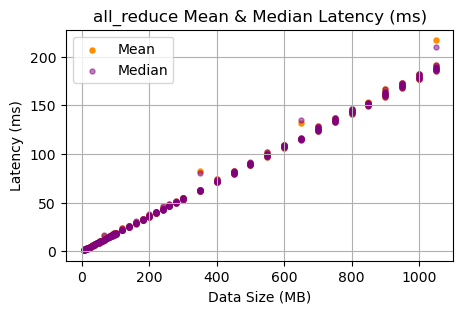

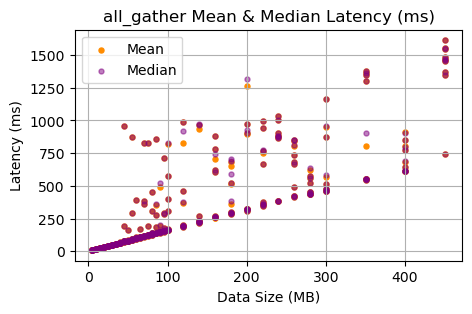

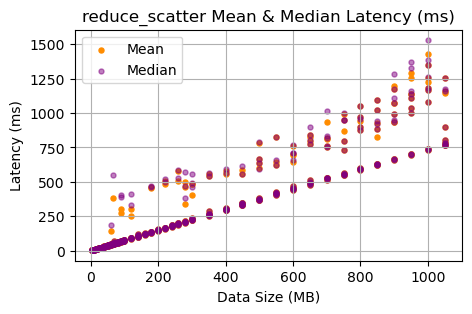

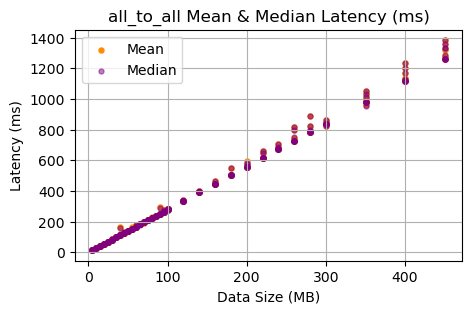

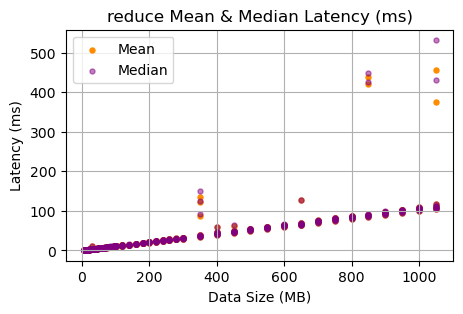

In [32]:
for collective in collectives:
    plot_mean_median_latency(collective)

# Straggler Delay

In [8]:
def plot_straggler_delay(collective: str):
    bench_df = get_bench_df(collective, async_op=False)
    strag_delay = bench_df.groupby(["experiment"]).agg({"time": np.ptp, "data_size":lambda x: x.iloc[0]}).loc[:, ["data_size", "time"]]
    bench_async_df = get_bench_df(collective, async_op=True)
    async_strag_delay = bench_async_df.groupby(["experiment"]).agg({"time": np.ptp, "data_size":lambda x: x.iloc[0]}).loc[:, ["data_size", "time"]]
    fig, axs = plt.subplots(2, figsize=[4,5], gridspec_kw={'hspace':0.5, 'wspace':0.3})

    axs[0].scatter(strag_delay["data_size"], strag_delay["time"], s=8, label="Synchronous")
    axs[0].scatter(async_strag_delay["data_size"], async_strag_delay["time"], s=8, label="Asynchronous", alpha=0.3, c="purple")
    axs[0].set_title(f"{collective} Straggler Delay (ms)")
    axs[0].set_xlabel("Data Size (MB)")
    axs[0].set_ylabel("Straggler Delay (ms)")
    axs[0].legend()
    axs[0].grid(True)

    time_variance = strag_delay.groupby(["data_size"]).var()
    async_time_variance = async_strag_delay.groupby(["data_size"]).var()
    sizes = strag_delay.groupby(["data_size"]).groups.keys()
    axs[1].scatter(sizes, time_variance, s=8, c="darkorange", label="Synchronous")
    axs[1].scatter(sizes, async_time_variance, s=8, c="green", alpha=0.3, label="Asynchronous")
    axs[1].set_title(f"{collective} Straggler Delay Variance")
    axs[1].set_xlabel("Data Size (MB)")
    axs[1].set_ylabel("Straggler Delay Variance")
    axs[1].legend()
    axs[1].grid(True)

    plt.savefig(f"figs/{collective}_straggler.png", bbox_inches="tight")

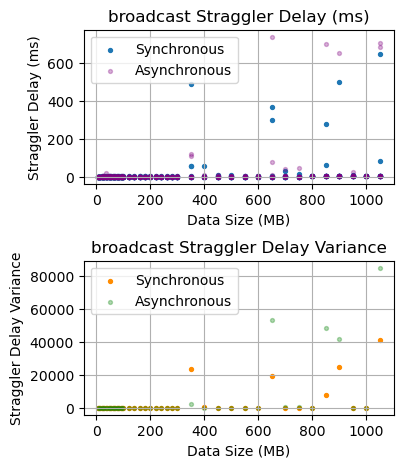

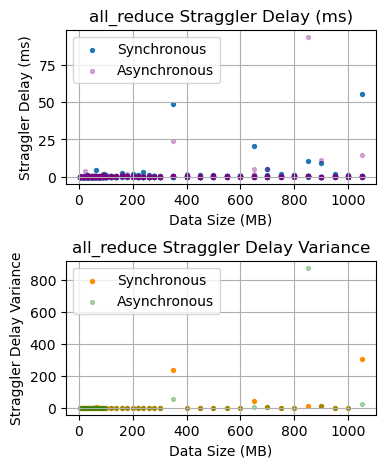

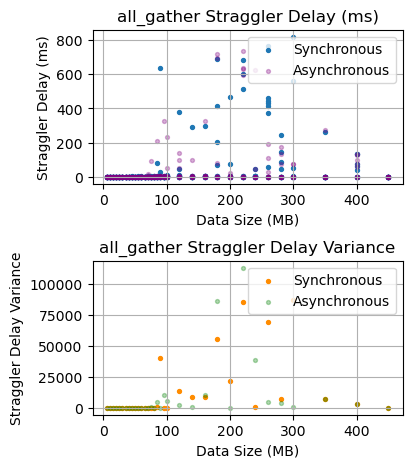

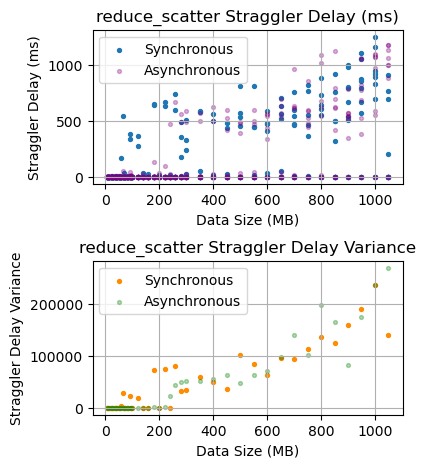

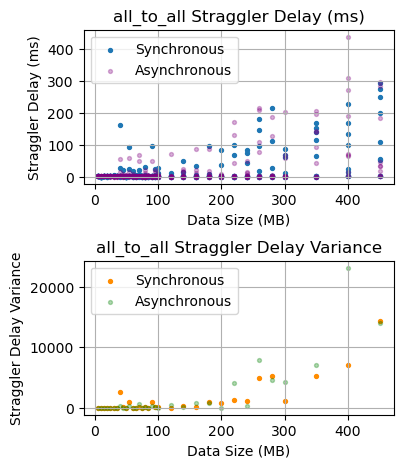

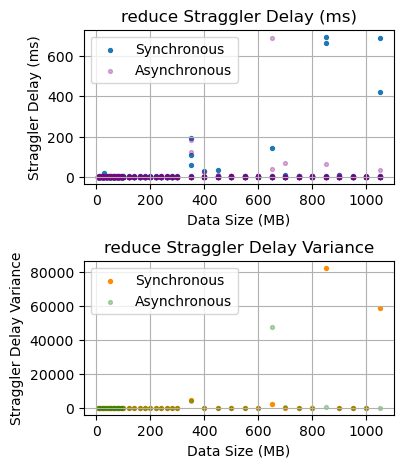

In [9]:
for collective in collectives:
    plot_straggler_delay(collective)

# Bandwidth Analysis

In [10]:
send_df = pd.read_csv("bw_results/bw_send.data", header=None).rename(columns={0:"data_size", 1:"time"})
send_df["bandwidth"] = send_df["data_size"]/send_df["time"]

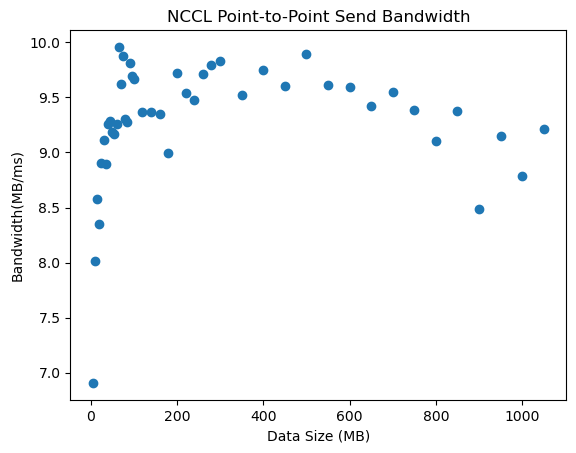

In [11]:
plt.scatter(send_df["data_size"], send_df["bandwidth"])
plt.title("NCCL Point-to-Point Send Bandwidth")
plt.xlabel("Data Size (MB)")
plt.ylabel("Bandwidth(MB/ms)")
plt.savefig("figs/send_bw.png")

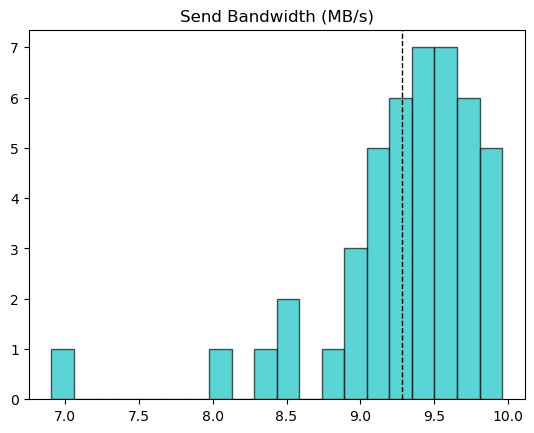

In [12]:
plt.hist(send_df["bandwidth"], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(send_df["bandwidth"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Send Bandwidth (MB/s)")
plt.savefig("figs/send_bw_hist.png")

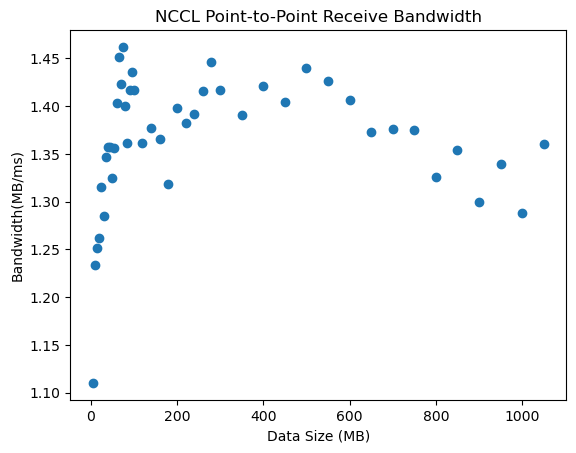

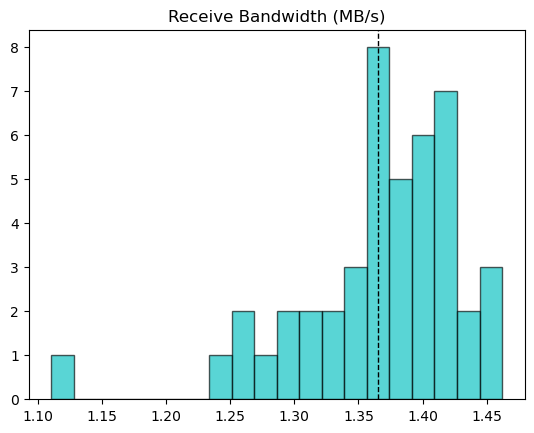

In [13]:
recv_df = pd.read_csv("bw_results/bw_recv.data", header=None).rename(columns={0:"data_size", 1:"time"})
recv_df["bandwidth"] = recv_df["data_size"]/recv_df["time"]

plt.figure()
plt.scatter(recv_df["data_size"], recv_df["bandwidth"])
plt.title("NCCL Point-to-Point Receive Bandwidth")
plt.xlabel("Data Size (MB)")
plt.ylabel("Bandwidth(MB/ms)")
plt.savefig("figs/recv_bw.png")

plt.figure()
plt.hist(recv_df["bandwidth"], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(recv_df["bandwidth"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Receive Bandwidth (MB/s)")
plt.savefig("figs/recv_bw_hist.png")

# Coalescing

In [14]:
def plot_coalescing(collective: str):
    bench_df = get_coal_df(collective, default=False)
    min_times_df = bench_df.groupby(["experiment"]).min().loc[:, ["data_size", "time"]]
    bench_def_df = get_coal_df(collective, default=True)
    min_times_def_df = bench_def_df.groupby(["experiment"]).min().loc[:, ["data_size", "time"]]

    fig, axs = plt.subplots(2, figsize=[4,5], gridspec_kw={'hspace':0.5, 'wspace':0.3})

    axs[0].scatter(min_times_df["data_size"], min_times_df["time"], s=8, label="Coalescing")
    axs[0].scatter(min_times_def_df["data_size"], min_times_def_df["time"], s=8, alpha=0.3, c="purple", label="Default")
    axs[0].set_title(f"{collective} Min Latency (ms)")
    axs[0].set_xlabel("Data Size (MB)")
    axs[0].set_ylabel("Latency (ms)")
    axs[0].legend()
    axs[0].grid(True)

    time_variance = min_times_df.groupby(["data_size"]).var()
    sizes = min_times_df.groupby(["data_size"]).groups.keys()
    time_async_variance = min_times_def_df.groupby(["data_size"]).var()
    axs[1].scatter(sizes, time_variance, s=8, c="darkorange", label="Coalescing")
    axs[1].scatter(sizes, time_async_variance, s=8, c="green", alpha=0.3, label="Default")
    axs[1].set_title(f"{collective} Min Latency Variance")
    axs[1].set_xlabel("Data Size (MB)")
    axs[1].set_ylabel("Latency Variance")
    axs[1].legend()
    axs[1].grid(True)

    plt.savefig(f"figs/{collective}_coalescing.png", bbox_inches="tight")

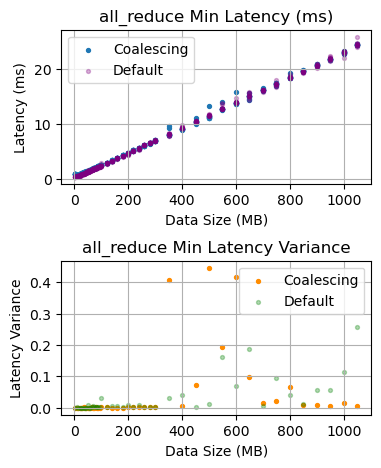

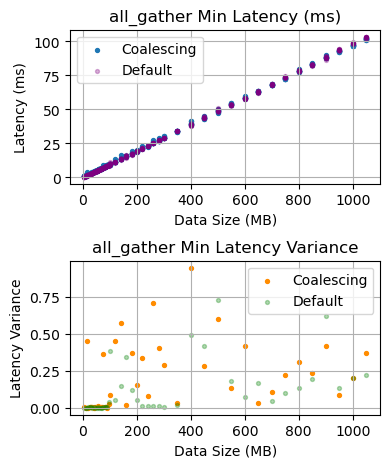

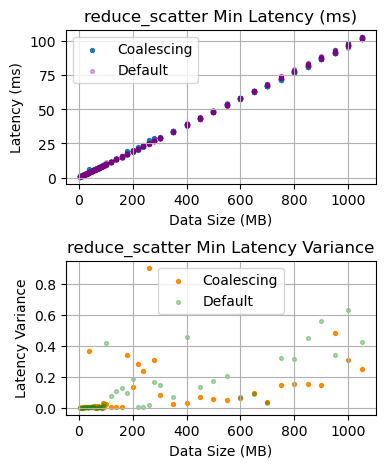

In [15]:
for collective in coalesce_collectives:
    plot_coalescing(collective)